# Cifar-10 이미지 분류
### 전체 데이터 사용
### Data Augmentation 적용
### 출처: [Achieving 90% accuracy in Object Recognition ](https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/)

In [1]:
import keras
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Activation, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Warning 무시
import warnings
warnings.filterwarnings('ignore')

#### CIFAR10 데이터 로드

In [3]:
(X_train, y_train0), (X_test, y_test0) = cifar10.load_data()
print(X_train.shape, X_train.dtype)
print(y_train0.shape, y_train0.dtype)
print(X_test.shape, X_test.dtype)
print(y_test0.shape, y_test0.dtype)

(50000, 32, 32, 3) uint8
(50000, 1) uint8
(10000, 32, 32, 3) uint8
(10000, 1) int32


#### 데이터 확인

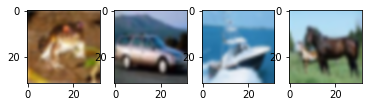

In [4]:
plt.subplot(141)
plt.imshow(X_train[0], interpolation="bicubic")
plt.grid(False)
plt.subplot(142)
plt.imshow(X_train[4], interpolation="bicubic")
plt.grid(False)
plt.subplot(143)
plt.imshow(X_train[8], interpolation="bicubic")
plt.grid(False)
plt.subplot(144)
plt.imshow(X_train[12], interpolation="bicubic")
plt.grid(False)
plt.show()

#### 자료형 변환 및 스케일링
- X: 실수형으로 정규화
- Y: 1-hot encoding
    * airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [5]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

print(X_train.shape, X_train.dtype)

(50000, 32, 32, 3) float32


In [6]:
Y_train = np_utils.to_categorical(y_train0, 10)
Y_test = np_utils.to_categorical(y_test0, 10)
Y_train[:4]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

#### 모형 구현

In [7]:
np.random.seed(0)
weight_decay = 1e-4

In [9]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay), 
                 input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

In [11]:
opt_rms = rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

In [12]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [13]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = MODEL_DIR + "v3" + "{epoch:02d}-{val_loss:.4f}.hdf5"
    
checkpoint = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, 
                             save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30)

In [16]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=128),
                    steps_per_epoch=X_train.shape[0] // 64, epochs=125,
                    verbose=1, validation_data=(X_test, Y_test),
                    callbacks=[LearningRateScheduler(lr_schedule), early_stopping_callback, checkpoint])

W0831 10:13:14.785777   628 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/125
781/781 [==============================] - 93s 119ms/step - loss: 1.6736 - acc: 0.4800 - val_loss: 1.2182 - val_acc: 0.6245

Epoch 00001: val_loss improved from inf to 1.21825, saving model to ./model/v301-1.2182.hdf5
Epoch 2/125
781/781 [==============================] - 102s 131ms/step - loss: 1.0645 - acc: 0.6527 - val_loss: 1.1614 - val_acc: 0.6622

Epoch 00002: val_loss improved from 1.21825 to 1.16143, saving model to ./model/v302-1.1614.hdf5
Epoch 3/125
781/781 [==============================] - 115s 147ms/step - loss: 0.9080 - acc: 0.7095 - val_loss: 0.8094 - val_acc: 0.7486

Epoch 00003: val_loss improved from 1.16143 to 0.80943, saving model to ./model/v303-0.8094.hdf5
Epoch 4/125
781/781 [==============================] - 116s 148ms/step - loss: 0.8166 - acc: 0.7437 - val_loss: 0.9150 - val_acc: 0.7434

Epoch 00004: val_loss did not improve from 0.80943
Epoch 5/125
781/781 [==============================] - 128s 163ms/step - loss: 0.7604 - acc: 0.7658 - val_loss:

781/781 [==============================] - 160s 205ms/step - loss: 0.4061 - acc: 0.9000 - val_loss: 0.4810 - val_acc: 0.8808

Epoch 00083: val_loss did not improve from 0.46198
Epoch 84/125
781/781 [==============================] - 144s 184ms/step - loss: 0.4024 - acc: 0.9006 - val_loss: 0.4830 - val_acc: 0.8853

Epoch 00084: val_loss did not improve from 0.46198
Epoch 85/125
781/781 [==============================] - 166s 212ms/step - loss: 0.4037 - acc: 0.8996 - val_loss: 0.5026 - val_acc: 0.8796

Epoch 00085: val_loss did not improve from 0.46198
Epoch 86/125
781/781 [==============================] - 161s 206ms/step - loss: 0.3998 - acc: 0.9001 - val_loss: 0.4531 - val_acc: 0.8916

Epoch 00086: val_loss improved from 0.46198 to 0.45309, saving model to ./model/v386-0.4531.hdf5
Epoch 87/125
781/781 [==============================] - 138s 177ms/step - loss: 0.3973 - acc: 0.9007 - val_loss: 0.4713 - val_acc: 0.8861

Epoch 00087: val_loss did not improve from 0.45309
Epoch 88/125
781/

#### 모델 평가하기

In [17]:
# Best Model 복원
from keras.models import load_model
del model
model = load_model('model/v3115-0.4134.hdf5')

In [18]:
scores = model.evaluate(X_test, Y_test, batch_size=128, verbose=1)
print('\nTest result: %.4f loss: %.4f' % (scores[1], scores[0]))

10000/10000 [==============================] - 2s 237us/step

Test result: 0.8940 loss: 0.4134


#### 그래프 그리기

In [19]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_acc']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['acc']

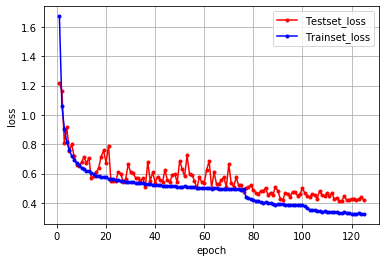

In [20]:
# 그래프로 표현
x_len = np.arange(1, len(y_loss)+1)
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

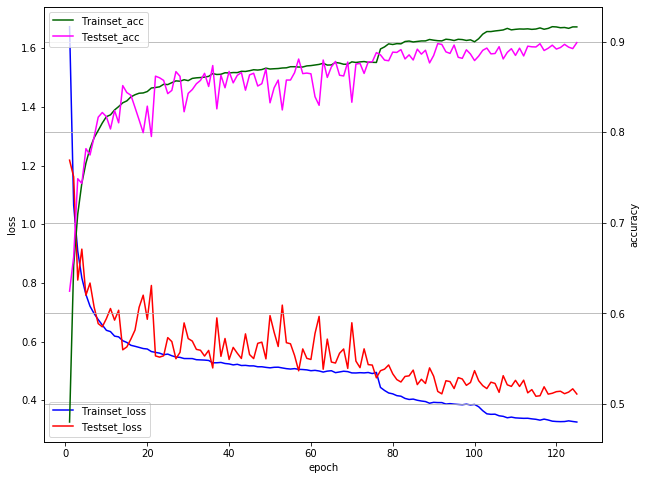

In [22]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower left')
ax1.legend(loc='upper left')
plt.grid()
plt.show()